In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import *
from time import time
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import ModelCheckpoint
namefile = 'vgg16 drpout 0.5'

HEIGHT = 224 #Input dimension for VGG16
WIDTH = 224

base_model = VGG16(include_top=False, #load the model with weights pretrained in ImageNet
                      weights='imagenet', 
                      input_shape=(HEIGHT, WIDTH, 3))

In [2]:
#Create imiages generator
VAL_DIR="Data/validation"
TRAIN_DIR = "Data/training"
BATCH_SIZE =3

train_datagen =  ImageDataGenerator(
      #preprocessing_function=preprocess_input,
      #rotation_range=45,
      rescale=1./255,
      #horizontal_flip=True,
      vertical_flip=True
    )

test_datagen = ImageDataGenerator(#preprocessing_function=preprocess_input,
                                 rescale=1./255,
                                 #horizontal_flip=True,
                                 #vertical_flip=True
                                 )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    #save_to_dir ="ImagenesKeras/train", save_prefix='',
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    interpolation='bicubic')
validation_generator = test_datagen.flow_from_directory(VAL_DIR,
                                                        target_size=(HEIGHT, WIDTH), 
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        #save_to_dir ="ImagenesKeras/val",save_prefix='',
                                                        )

Found 1401 images belonging to 21 classes.
Found 200 images belonging to 21 classes.


In [3]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers[:-4]: #freeze the layers except the last 4 layers
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["LetraA", "LetraB", "LetraC","LetraD","LetraE","LetraF","LetraG","LetraH","LetraI","LetraL",
             "LetraM","LetraN","LetraO","LetraP","LetraR","LetraS","LetraT","LetraU","LetraV","LetraW","LetraY"]
FC_LAYERS = [1024, 512]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
for layer in finetune_model.layers: #show the layers for that can be trained
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000020C715144A8> False
<keras.layers.convolutional.Conv2D object at 0x0000020C77B934E0> False
<keras.layers.convolutional.Conv2D object at 0x0000020C77B93EB8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000020C77BD44A8> False
<keras.layers.convolutional.Conv2D object at 0x0000020C77BD47F0> False
<keras.layers.convolutional.Conv2D object at 0x0000020C77C0D828> False
<keras.layers.pooling.MaxPooling2D object at 0x0000020C77C28A90> False
<keras.layers.convolutional.Conv2D object at 0x0000020C77C28AC8> False
<keras.layers.convolutional.Conv2D object at 0x0000020C77C5F400> False
<keras.layers.convolutional.Conv2D object at 0x0000020C77C74C88> False
<keras.layers.pooling.MaxPooling2D object at 0x0000020C77CA8CF8> False
<keras.layers.convolutional.Conv2D object at 0x0000020C77CA8EB8> False
<keras.layers.convolutional.Conv2D object at 0x0000020C77CC4B70> False
<keras.layers.convolutional.Conv2D object at 0x0000020C77CF0CF8> False
<ker

In [6]:
import matplotlib.pyplot as plt #plot accuaracy and fuction loss in train and validation stage
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'b')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
467/467 [==============================] - 78s 166ms/step - loss: 2.9984 - acc: 0.1078 - val_loss: 2.3283 - val_acc: 0.3900

Epoch 00001: val_loss improved from inf to 2.32832, saving model to bestmodel_vgg16 drpout 0.5.h5


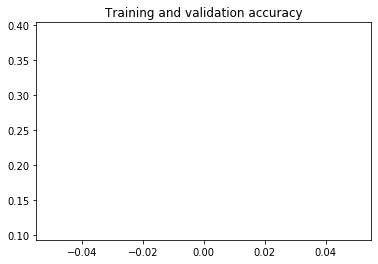

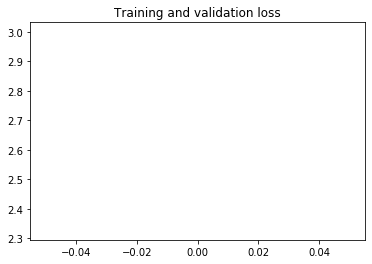

<Figure size 432x288 with 0 Axes>

In [7]:
#
NUM_EPOCHS = 15
num_train_images = 1277

optimizer=RMSprop(lr=1e-5)
finetune_model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

filepath='bestmodel_' + namefile + '.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',  verbose=1, save_best_only=True,
                             mode='min', period=1)
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=3, 
                                       steps_per_epoch=len(train_generator), 
                                       shuffle=True, callbacks=callbacks_list, validation_data=validation_generator,validation_steps=len(validation_generator))


plot_training(history)

In [ ]:
# model evaluation
finetune_model.load_weights('bestmodel_' + namefile + '.h5')

score_train = finetune_model.evaluate_generator(train_generator, steps=89)
print('training', score_train)
score_val = finetune_model.evaluate_generator(validation_generator, steps=89)
print('validation', score_val)

In [ ]:
#if necessary you can load the model for future analysis
from keras.models import load_model
finetune_model = load_model('bestmodel_' + namefile + '.h5') 

In [9]:
#load image and Cargar una imagen y realizar procesamiento para la entrada del Modelo
import imageio
from skimage.transform import resize
from skimage.measure import moments_hu
import numpy as np

image_file1 = 'C:/Users/Luis/Documents/Y.JPG'
img_original = imageio.imread(image_file1)
img = resize(img_original, (HEIGHT, WIDTH) ,mode = 'constant')

img1 = np.expand_dims(img, axis=0)
img1.shape

(1, 224, 224, 3)

In [13]:
#With this fuction you can see any layer in the model
from keras import backend as K
model = finetune_model
# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[3].output])

layer_output = get_3rd_layer_output([img1]) # img1 es la imagen de entrada, se introduce al modelo
layer_see = layer_output[0] #se optiene la lista de salida de la capa

print(layer_see.shape)

(1, 112, 112, 64)


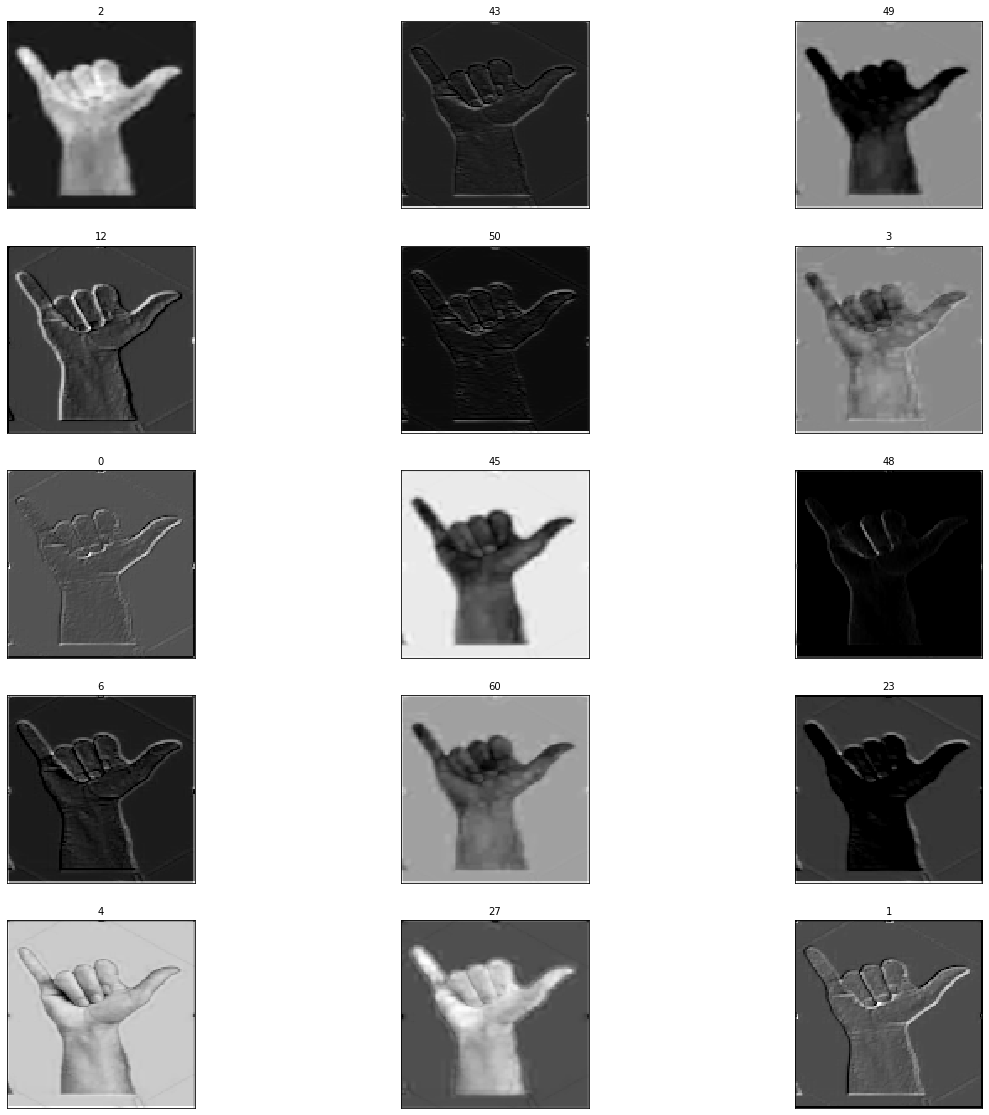

In [14]:
plt.rcParams['figure.figsize'] = (20,20) # Hacer las figuras más grandes
arr = np.arange(layer_see.shape[3])

np.random.shuffle(arr)
g=1
for i in arr[0:15]:
    
    plt.subplot(5,3,g)
    plt.imshow(layer_see[0,:,:,i], cmap='gray')     
    
    plt.title(str(i), fontsize=10)
    plt.tick_params(axis='both',which='both',bottom=False, left=False,labelbottom=False,labelleft=False) 
    g += 1
#plt.savefig('fotos_filtros3655_50-100' + namefile +'.pdf', bbox_inches='tight')
plt.show()

In [15]:
def Letras(i):
        switcher={
                0:'Letra A',
                1:'Letra B',
                2:'Letra C',
                3:'Letra D',
                4:'Letra E',
                5:'Letra F',
                6:'Letra G',
                7:'Letra H',
                8:'Letra I',
                9:'Letra L',
                10:'Letra M',
                11:'Letra N',
                12:'Letra O',
                13:'Letra P',
                14:'Letra R',
                15:'Letra S',
                16:'Letra T',
                17:'Letra U',
                18:'Letra V',
                19:'Letra W',
                20:'Letra Y'
                    }
        return switcher.get(i,"INVALIDO NO HAY SEÑA")

In [17]:
from time import time

tiempo_inicial = time() 
re=finetune_model.predict(img1)
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial
 
print ('Run time:',tiempo_ejecucion) #Seconds

print(re)
print(Letras(re.argmax()))

Run time: 0.035866498947143555
[[0.0565697  0.04580356 0.03707798 0.05492168 0.06949536 0.02850633
  0.07805274 0.08315243 0.04439006 0.06748453 0.0376946  0.05563271
  0.02865157 0.04428164 0.03017995 0.07066371 0.03366656 0.02750538
  0.01931828 0.05162027 0.035331  ]]
Letra H
